In [1]:
# import time libraries
import time
from datetime import datetime
from time import gmtime, strftime

# Set Begin Time to Measure Time to Run of Whole Notebook
begin_time = time.time()

## Import Libraries and Set Options

In [2]:
# Standard Libraries

import pandas as pd
import numpy as np
import os
import math
import requests
from io import StringIO
import sys
import os.path
from IPython.display import display, HTML

# For Model Training
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import xgboost as feature_names

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score

# For Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Building Histograms
from scipy.stats import norm
import matplotlib.mlab as mlab
import scipy.stats as st
import scipy.stats
from scipy import stats

bold = "\033[1m"
reset = "\033[0;0m"

### Create Functions

In [3]:
### Create a Function to Build Histograms

def histogram(variable, name, color, bins):
    
    totalVals = variable.count
    missings = variable.isnull().sum(axis = 0).sum()
    variable2 = variable.dropna()
   
    # best fit of data
    (mu, sigma) = norm.fit(variable2)

    # the histogram of the data
    n, bins, patches = plt.hist(variable2, bins, density = True, facecolor = color, alpha = 0.75)
    
    # add a 'best fit' line
    y = scipy.stats.norm.pdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'r--', linewidth = 2)

    #plot
    plt.xlabel(name + ': Missings = ' + str(missings))
    plt.ylabel('Probability')
    plt.title(r'$\mathrm{Histogram\ of\ ' + name + ':}\ \mu =%.3f,\ \sigma =%.3f$' %(mu, sigma))
    plt.grid(True)

    plt.show()

In [4]:
# Load DataFrames

os.chdir(sys.path[0] + '\\Data')

df_all = pd.read_pickle('df_all_2.pkl')

df_categorical = pd.read_pickle('df_categorical_2.pkl')
df_continuous = pd.read_pickle('df_continuous_2.pkl')

ColumnList = df_all.columns.tolist()

display(HTML(df_all[0:5].to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
1459,1,train,65,19.212182,7,5,8.059126,11,0,150,11,11.692623,854,0.0,13.698888,1,0,2,1,3,0.730463,8,0,2,548.0,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,122476.943202,7.0,7.0,7,2.0,14.976591,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1460,2,train,80,19.712205,6,8,0.000000,12,0,284,12,12.792276,0,0.0,12.792276,0,0,2,0,3,0.730463,6,1,2,460.0,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,121090.109327,34.0,34.0,34,3.0,14.923100,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1461,3,train,68,20.347241,7,5,7.646538,10,0,434,11,11.892039,866,0.0,13.832085,1,0,2,1,3,0.730463,6,1,2,608.0,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,123171.666930,9.0,8.0,9,2.0,15.149678,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
RemoveList = ['Id','segment','SalePrice']

for i in range(0, len(RemoveList)):
    ColumnList.remove(RemoveList[i])

print(bold + 'Column List \n' + reset, ColumnList, '\n')

for i in range(0,len(ColumnList)):
    if df_all[ColumnList[i]].dtype == 'object':
        df_all[ColumnList[i]] = df_all[ColumnList[i]]
    elif df_all[ColumnList[i]].dtype == 'float32':
        df_all[ColumnList[i]] = int(df_all[ColumnList[i]])
    elif df_all[ColumnList[i]].dtype == 'float64':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    elif df_all[ColumnList[i]].dtype == 'int64':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    elif df_all[ColumnList[i]].dtype == 'uint8':
        df_all[ColumnList[i]] = df_all[ColumnList[i]].fillna(0).astype(np.int32)
    else:
        df_all[ColumnList[i]] = df_all[ColumnList[i]]
        
df_all.info()

Column List 
 ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'TotalSF', 'MSZoning_Other', 'MSZoning_RL', 'MSZoning_RM', 'Alley_None', 'Alley_Other', 'LotShape_IR1', 'LotShape_Other', 'LotShape_Reg', 'LandContour_Lvl', 'LandContour_Other', 'LotConfig_Corner', 'LotConfig_CulDSac', 'LotConfig_Inside', 'LotConfig_Other', 'Neighborhood_BrkSide', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NWAmes', 'Neighborhood_NridgHt', 'Neighborhood_O

In [6]:
df_train = df_all[df_all['segment'] == 'train']
df_test = df_all[df_all['segment'] == 'test']

# Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

display(HTML(df_train[0:5].to_html()))
display(HTML(df_train.tail().to_html()))

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
1459,1,train,65,19,7,5,8,11,0,150,11,11,854,0,13,1,0,2,1,3,0,8,0,2,548,0,5,0,0,0,0,0,122476.943202,7,7,7,2,14,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0
1460,2,train,80,19,6,8,0,12,0,284,12,12,0,0,12,0,0,2,0,3,0,6,1,2,460,9,0,0,0,0,0,0,121090.109327,34,34,34,3,14,0,1,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0
1461,3,train,68,20,7,5,7,10,0,434,11,11,866,0,13,1,0,2,1,3,0,6,1,2,608,0,5,0,0,0,0,0,123171.666930,9,8,9,2,15,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
1462,4,trai

,Id,segment,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold,TotalSF,MSZoning_Other,MSZoning_RL,MSZoning_RM,Alley_None,Alley_Other,LotShape_IR1,LotShape_Other,LotShape_Reg,LandContour_Lvl,LandContour_Other,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_Other,Neighborhood_BrkSide,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NWAmes,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_Other,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Condition1_Feedr,Condition1_Norm,Condition1_Other,BldgType_1Fam,BldgType_Other,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1Story,HouseStyle_2Story,HouseStyle_Other,RoofStyle_Gable,RoofStyle_Hip,RoofStyle_Other,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Other,Exterior1st_Plywood,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior2nd_HdBoard,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Other,MasVnrType_Stone,ExterQual_Gd,ExterQual_Other,ExterQual_TA,ExterCond_Gd,ExterCond_Other,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_Other,Foundation_PConc,BsmtQual_Ex,BsmtQual_Gd,BsmtQual_Other,BsmtQual_TA,BsmtCond_Other,BsmtCond_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_Other,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_Other,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_Other,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Gd,HeatingQC_Other,HeatingQC_TA,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_Other,Electrical_SBrkr,KitchenQual_Ex,KitchenQual_Gd,KitchenQual_Other,KitchenQual_TA,Functional_Other,Functional_Typ,FireplaceQu_Gd,FireplaceQu_None,FireplaceQu_Other,FireplaceQu_TA,GarageType_Attchd,GarageType_BuiltIn,GarageType_Detchd,GarageType_None,GarageType_Other,GarageFinish_Fin,GarageFinish_None,GarageFinish_RFn,GarageFinish_Unf,GarageQual_None,GarageQual_Other,GarageQual_TA,GarageCond_None,GarageCond_Other,GarageCond_TA,PavedDrive_N,PavedDrive_Other,PavedDrive_Y,Fence_MnPrv,Fence_None,Fence_Other,SaleType_New,SaleType_Other,SaleType_WD,SaleCondition_Abnorml,SaleCondition_Normal,SaleCondition_Other,SaleCondition_Partial,MSSubClass_band_gt_80,MSSubClass_band_lt_20,MSSubClass_band_lt_50,MSSubClass_band_lt_80,MoSold_band_Q1,MoSold_band_Q2,MoSold_band_Q3,MoSold_band_Q4
2914,1456,train,62,18,6,5,0,0,0,953,11,11,694,0,13,0,0,2,1,3,0,7,1,2,460,0,4,0,0,0,0,0,120725.412529,11,10,11,3,15,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0
2915,1457,train,85,20,6,6,7,11,7,589,13,14,0,0,14,1,0,2,0,3,0,7,2,2,500,9,0,0,0,0,0,0,122548.628097,32,22,32,0,16,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0
2916,1458,train,66,19,7,9,0,8,0,877,12,12,1152,0,14,0,0,2,0,4,0,9,2,1,252,0,5,0,0,0,0,14,124931.295226,69,4,69,0,16,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,1,0

In [7]:
y = df_train['SalePrice'].values.astype(int)
X = df_train[ColumnList].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X

array([[65, 19,  7, ...,  0,  0,  0],
       [80, 19,  6, ...,  1,  0,  0],
       [68, 20,  7, ...,  0,  1,  0],
       ...,
       [66, 19,  7, ...,  1,  0,  0],
       [68, 19,  5, ...,  1,  0,  0],
       [75, 19,  5, ...,  1,  0,  0]])

In [8]:
dtrain = xgb.DMatrix(X_train, label = y_train, feature_names = ColumnList, missing = -99)
dtest = xgb.DMatrix(X_test, label = y_test, feature_names = ColumnList, missing = -99)

In [9]:
# Build the Baseline Model

# "Learn" the mean from the training data
mean_train = np.mean(y_train)

# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train

# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)

print("Baseline MAE is {:.2f}".format(mae_baseline))

Baseline MAE is 3102.81


In [10]:
# Define Default Parameters

params = {
    
# Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    'n_estimators':1000,
    'missing':-99,
    
# Other parameters
    'objective':'reg:linear',
    'silent': True
}

params['eval_metric'] = "mae"

# We still need to pass a num_boost_round which corresponds to the maximum number of boosting rounds that we allow.
# We set it to a large value hoping to find the optimal number of rounds before reaching it,
# if we haven't improved performance on our test dataset in early_stopping_round rounds

boosting_rounds = 999
stop_rounds = 20

In [11]:
%%time

# Here we will use our dtest DMatrix.
# early_stopping_rounds: The number of rounds without improvements after which we should stop, here we set it to 10.

model = xgb.train(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = stop_rounds
)

print("Best MAE: {:.2f} with {} rounds".format(model.best_score,model.best_iteration+1))

[0]	Test-mae:83943
Will train until Test-mae hasn't improved in 20 rounds.
[1]	Test-mae:58729.4
[2]	Test-mae:41081.5
[3]	Test-mae:28735.8
[4]	Test-mae:20115.9
[5]	Test-mae:14051.1
[6]	Test-mae:9813.92
[7]	Test-mae:6862.05
[8]	Test-mae:4874.84
[9]	Test-mae:3487.2
[10]	Test-mae:2545.89
[11]	Test-mae:1939.89
[12]	Test-mae:1575.96
[13]	Test-mae:1370.73
[14]	Test-mae:1239.88
[15]	Test-mae:1161.08
[16]	Test-mae:1113.92
[17]	Test-mae:1093.47
[18]	Test-mae:1080.75
[19]	Test-mae:1071.89
[20]	Test-mae:1057.98
[21]	Test-mae:1053.19
[22]	Test-mae:1046.17
[23]	Test-mae:1035.46
[24]	Test-mae:1035.17
[25]	Test-mae:1029.98
[26]	Test-mae:1023.06
[27]	Test-mae:1022.72
[28]	Test-mae:1021.76
[29]	Test-mae:1021.12
[30]	Test-mae:1017.13
[31]	Test-mae:1012.86
[32]	Test-mae:1011.95
[33]	Test-mae:1009.74
[34]	Test-mae:1012.56
[35]	Test-mae:1012.59
[36]	Test-mae:1010.21
[37]	Test-mae:1012.04
[38]	Test-mae:1010.64
[39]	Test-mae:1014.2
[40]	Test-mae:1014.27
[41]	Test-mae:1011.84
[42]	Test-mae:1010.44
[43]	Test-ma

In [12]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    seed = 42,
    nfold = 5,
    metrics = {'mae'},
    early_stopping_rounds = stop_rounds
)

display(HTML(cv_results.head(n=5).to_html()))
display(HTML(cv_results.tail(n=5).to_html()))
print(cv_results['test-mae-mean'].min())

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,84280.845313,57.962658,84281.034375,356.185088
1,59027.478125,40.597852,59027.669531,373.549764
2,41362.866406,28.382529,41383.311719,360.815409
3,28984.507813,19.903674,28987.952344,296.721648
4,20324.237109,13.041235,20329.822265,261.230178


,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
48,144.367169,10.009595,1027.766223,37.073221
49,139.510428,10.258835,1027.741370,37.415663
50,134.199812,10.643253,1027.094421,37.051176
51,128.267111,8.846827,1025.506970,35.888468
52,123.930195,8.148943,1025.127991,35.577404


1025.1279906
Wall time: 753 ms


In [13]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for eta in [.2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))

# We update our parameters
    params['eta'] = eta

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params
print(params['eta'])

CV with eta=0.2
	MAE 975.4979126000001 for 71 rounds

CV with eta=0.1
	MAE 939.7426024 for 275 rounds

CV with eta=0.05
	MAE 927.7070678 for 355 rounds

CV with eta=0.01
	MAE 935.5453246000001 for 998 rounds

CV with eta=0.005
	MAE 1286.4776613999998 for 998 rounds

Best params: 0.05, MAE: 927.7070678
0.05
Wall time: 23.3 s


In [14]:
# You can try wider intervals with a larger step between each value and then narrow it down.
# Here after several iteration I found that the optimal value was in the following ranges.

# range(9,12) --> [int(x) for x in np.linspace(start = 4, stop = 20, num = 8)]
# range(5,8) --> [int(x) for x in np.linspace(start = 2, stop = 10, num = 8)]

gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in [int(x) for x in np.linspace(start = 4, stop = 20, num = 4)]
    for min_child_weight in [int(x) for x in np.linspace(start = 4, stop = 16, num = 4)]
]

In [15]:
%%time

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))

# Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

# Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds = stop_rounds
    )

# Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

print(params['max_depth'])
print(params['min_child_weight'])

CV with max_depth=4, min_child_weight=4
	MAE 888.1105345999998 for 600 rounds
CV with max_depth=4, min_child_weight=8
	MAE 896.0425782 for 489 rounds
CV with max_depth=4, min_child_weight=12
	MAE 913.4476195999999 for 317 rounds
CV with max_depth=4, min_child_weight=16
	MAE 905.640503 for 466 rounds
CV with max_depth=9, min_child_weight=4
	MAE 931.7111206 for 323 rounds
CV with max_depth=9, min_child_weight=8
	MAE 918.7484864 for 247 rounds
CV with max_depth=9, min_child_weight=12
	MAE 924.551709 for 253 rounds
CV with max_depth=9, min_child_weight=16
	MAE 916.7838624 for 216 rounds
CV with max_depth=14, min_child_weight=4
	MAE 944.2302367999998 for 235 rounds
CV with max_depth=14, min_child_weight=8
	MAE 934.1126099999999 for 181 rounds
CV with max_depth=14, min_child_weight=12
	MAE 927.4596558 for 167 rounds
CV with max_depth=14, min_child_weight=16
	MAE 915.1693359999999 for 201 rounds
CV with max_depth=20, min_child_weight=4
	MAE 940.7529664 for 273 rounds
CV with max_depth=20, min

In [16]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(6,11)]
    for colsample in [i/10. for i in range(6,11)]
]

In [17]:
%%time

min_mae = float("Inf")
best_params = None

# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample,colsample))

# We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample

# Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round = boosting_rounds,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds = stop_rounds
    )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)

print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

print(params['subsample'])
print(params['colsample_bytree'])

CV with subsample=1.0, colsample=1.0
	MAE 888.1105345999998 for 600 rounds
CV with subsample=1.0, colsample=0.9
	MAE 895.948694 for 423 rounds
CV with subsample=1.0, colsample=0.8
	MAE 891.2276126 for 487 rounds
CV with subsample=1.0, colsample=0.7
	MAE 887.8724490000001 for 479 rounds
CV with subsample=1.0, colsample=0.6
	MAE 887.7191406 for 667 rounds
CV with subsample=0.9, colsample=1.0
	MAE 891.1257934000001 for 362 rounds
CV with subsample=0.9, colsample=0.9
	MAE 874.3088866 for 716 rounds
CV with subsample=0.9, colsample=0.8
	MAE 875.7806154 for 581 rounds
CV with subsample=0.9, colsample=0.7
	MAE 874.7772580000001 for 563 rounds
CV with subsample=0.9, colsample=0.6
	MAE 877.0462036000001 for 442 rounds
CV with subsample=0.8, colsample=1.0
	MAE 888.2848388 for 430 rounds
CV with subsample=0.8, colsample=0.9
	MAE 888.5950928 for 432 rounds
CV with subsample=0.8, colsample=0.8
	MAE 888.6421998 for 430 rounds
CV with subsample=0.8, colsample=0.7
	MAE 891.9694212 for 477 rounds
CV wi

In [18]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

# for gamma in [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]:
for gamma in [0.00, 0.050, 0.50, 1.00, 5.00, 10.00]:
    print("CV with gamma={}".format(gamma))

# We update our parameters
    params['gamma'] = gamma

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = gamma

print("Best params: {}, MAE: {}".format(best_params, min_mae))


params['gamma'] = best_params
# params['gamma'] = 0

print(params['gamma'])

CV with gamma=0.0
	MAE 870.0552857999999 for 442 rounds

CV with gamma=0.05
	MAE 870.0552857999999 for 442 rounds

CV with gamma=0.5
	MAE 870.0552857999999 for 442 rounds

CV with gamma=1.0
	MAE 870.0552857999999 for 442 rounds

CV with gamma=5.0
	MAE 870.0552857999999 for 442 rounds

CV with gamma=10.0
	MAE 870.0552857999999 for 442 rounds

Best params: 0.0, MAE: 870.0552857999999
0.0
Wall time: 20.1 s


In [19]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for alpha in [1e-5, 1e-2, 0.1, 1, 100]:
    print("CV with alpha={}".format(alpha))

# We update our parameters
    params['reg_alpha'] = alpha

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = alpha

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['reg_alpha'] = best_params

print(params['reg_alpha'])

CV with alpha=1e-05
	MAE 870.0553101999998 for 442 rounds

CV with alpha=0.01
	MAE 870.0553465999999 for 442 rounds

CV with alpha=0.1
	MAE 870.413733 for 432 rounds

CV with alpha=1
	MAE 872.1307371999999 for 425 rounds

CV with alpha=100
	MAE 864.2675294000001 for 520 rounds

Best params: 100, MAE: 864.2675294000001
100
Wall time: 16.1 s


In [20]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for lambdaVal in [1e-5, 1e-2, 0.1, 1, 10, 100]:
    print("CV with lambda = {}".format(lambdaVal))

# We update our parameters
    params['reg_lambda'] = lambdaVal

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = lambdaVal

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['reg_lambda'] = best_params

print(params['reg_lambda'])

CV with lambda = 1e-05
	MAE 906.4098022000001 for 244 rounds

CV with lambda = 0.01
	MAE 901.5056885999999 for 249 rounds

CV with lambda = 0.1
	MAE 889.2399412000001 for 328 rounds

CV with lambda = 1
	MAE 864.2675294000001 for 520 rounds

CV with lambda = 10
	MAE 904.041553 for 445 rounds

CV with lambda = 100
	MAE 931.7452392000001 for 824 rounds

Best params: 1, MAE: 864.2675294000001
1
Wall time: 20.6 s


In [21]:
%%time

# This can take some time…
min_mae = float("Inf")
best_params = None

for booster in ['gbtree', 'gblinear']:
    print("CV with booster={}".format(booster))

# We update our parameters
    params['booster'] = booster

# Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round = boosting_rounds,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds = stop_rounds
          )

# Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    #boost_rounds = cv_results['test-mae-mean'].argmin()
    boost_rounds = cv_results['test-mae-mean'].idxmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = booster

print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['booster'] = best_params

print(params['booster'])

CV with booster=gbtree
	MAE 864.2675294000001 for 520 rounds

CV with booster=gblinear
	MAE 2284.460791 for 998 rounds

Best params: gbtree, MAE: 864.2675294000001
gbtree
Wall time: 8.3 s


In [22]:
# Final Dictionary
params

{'max_depth': 4,
 'min_child_weight': 4,
 'eta': 0.05,
 'subsample': 0.7,
 'colsample_bytree': 0.9,
 'n_estimators': 1000,
 'missing': -99,
 'objective': 'reg:linear',
 'silent': True,
 'eval_metric': 'mae',
 'gamma': 0.0,
 'reg_alpha': 100,
 'reg_lambda': 1,
 'booster': 'gbtree'}

In [23]:
# Let's train a model with it and see how well it does on our test set!

model = xgb.train(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    evals=[(dtest, "Test")],
    early_stopping_rounds = 10
)

print("Best MAE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[0]	Test-mae:113997
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:108292
[2]	Test-mae:102861
[3]	Test-mae:97709.2
[4]	Test-mae:92818.1
[5]	Test-mae:88171.5
[6]	Test-mae:83751.4
[7]	Test-mae:79549.4
[8]	Test-mae:75555
[9]	Test-mae:71762.8
[10]	Test-mae:68162.2
[11]	Test-mae:64752.5
[12]	Test-mae:61508.7
[13]	Test-mae:58426.4
[14]	Test-mae:55502
[15]	Test-mae:52721.4
[16]	Test-mae:50082.5
[17]	Test-mae:47573
[18]	Test-mae:45188
[19]	Test-mae:42923.1
[20]	Test-mae:40777.5
[21]	Test-mae:38736.4
[22]	Test-mae:36804.8
[23]	Test-mae:34955.6
[24]	Test-mae:33202.2
[25]	Test-mae:31530.9
[26]	Test-mae:29957.8
[27]	Test-mae:28455.9
[28]	Test-mae:27021.4
[29]	Test-mae:25672.1
[30]	Test-mae:24383.8
[31]	Test-mae:23168.6
[32]	Test-mae:22007
[33]	Test-mae:20906.1
[34]	Test-mae:19850.5
[35]	Test-mae:18861.8
[36]	Test-mae:17917.7
[37]	Test-mae:17025.3
[38]	Test-mae:16172.6
[39]	Test-mae:15361.6
[40]	Test-mae:14592.4
[41]	Test-mae:13858.8
[42]	Test-mae:13161.7
[43]	Test-mae:12500
[

In [24]:
# Let's train a model with it and see how well it does on our test set!

num_boost_round = model.best_iteration + 1

best_model = xgb.train(
    params,
    dtrain,
    #num_boost_round = boosting_rounds,
    num_boost_round = num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-mae:113997
[1]	Test-mae:108292
[2]	Test-mae:102861
[3]	Test-mae:97709.2
[4]	Test-mae:92818.1
[5]	Test-mae:88171.5
[6]	Test-mae:83751.4
[7]	Test-mae:79549.4
[8]	Test-mae:75555
[9]	Test-mae:71762.8
[10]	Test-mae:68162.2
[11]	Test-mae:64752.5
[12]	Test-mae:61508.7
[13]	Test-mae:58426.4
[14]	Test-mae:55502
[15]	Test-mae:52721.4
[16]	Test-mae:50082.5
[17]	Test-mae:47573
[18]	Test-mae:45188
[19]	Test-mae:42923.1
[20]	Test-mae:40777.5
[21]	Test-mae:38736.4
[22]	Test-mae:36804.8
[23]	Test-mae:34955.6
[24]	Test-mae:33202.2
[25]	Test-mae:31530.9
[26]	Test-mae:29957.8
[27]	Test-mae:28455.9
[28]	Test-mae:27021.4
[29]	Test-mae:25672.1
[30]	Test-mae:24383.8
[31]	Test-mae:23168.6
[32]	Test-mae:22007
[33]	Test-mae:20906.1
[34]	Test-mae:19850.5
[35]	Test-mae:18861.8
[36]	Test-mae:17917.7
[37]	Test-mae:17025.3
[38]	Test-mae:16172.6
[39]	Test-mae:15361.6
[40]	Test-mae:14592.4
[41]	Test-mae:13858.8
[42]	Test-mae:13161.7
[43]	Test-mae:12500
[44]	Test-mae:11870
[45]	Test-mae:11278.9
[46]	Test-mae:1

In [25]:
mean_absolute_error(best_model.predict(dtest), y_test)

880.6235730593608

In [26]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round = boosting_rounds,
    #num_boost_round = 500,
    seed = 42,
    nfold = 5,
    metrics = {'mae'},
    early_stopping_rounds = stop_rounds
)

Wall time: 3.84 s


In [27]:
print(cv_results.head(n=5))
print(cv_results.tail(n=5))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   114329.896875      79.412500  114330.085938    334.748426
1   108622.518750      75.408959  108622.710938    338.764371
2   103203.484375      69.726262  103203.678125    344.554785
3    98051.484375      64.333794   98051.673438    350.047750
4    93155.556250      58.105944   93155.748437    356.403656
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
516      243.730591      10.296792     864.581689     59.180147
517      243.190247      10.339496     864.600757     59.250339
518      242.667697      10.383092     864.428039     59.050432
519      242.139063      10.263890     864.450122     59.049865
520      241.420502      10.241906     864.267529     59.015839


In [28]:
%%time

# Let's see what cross-validation score we get with our current parameters:

cv_results2 = xgb.cv(
    params,
    dtrain,
    #num_boost_round = boosting_rounds,
    num_boost_round = 500,
    seed = 42,
    nfold = 5,
    metrics = {'mae'}
    #early_stopping_rounds = stop_rounds
)

Wall time: 3.57 s


In [29]:
print(cv_results2.head(n=5))
print(cv_results2.tail(n=5))

   train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
0   114329.896875      79.412500  114330.085938    334.748426
1   108622.518750      75.408959  108622.710938    338.764371
2   103203.484375      69.726262  103203.678125    344.554785
3    98051.484375      64.333794   98051.673438    350.047750
4    93155.556250      58.105944   93155.748437    356.403656
     train-mae-mean  train-mae-std  test-mae-mean  test-mae-std
495      256.096179      10.786948     864.739868     59.367512
496      255.554019      10.815468     864.708496     59.401939
497      254.898001      10.690871     864.961597     59.313959
498      254.349631      10.635879     864.627441     59.715088
499      253.791132      10.578743     864.683105     59.432859


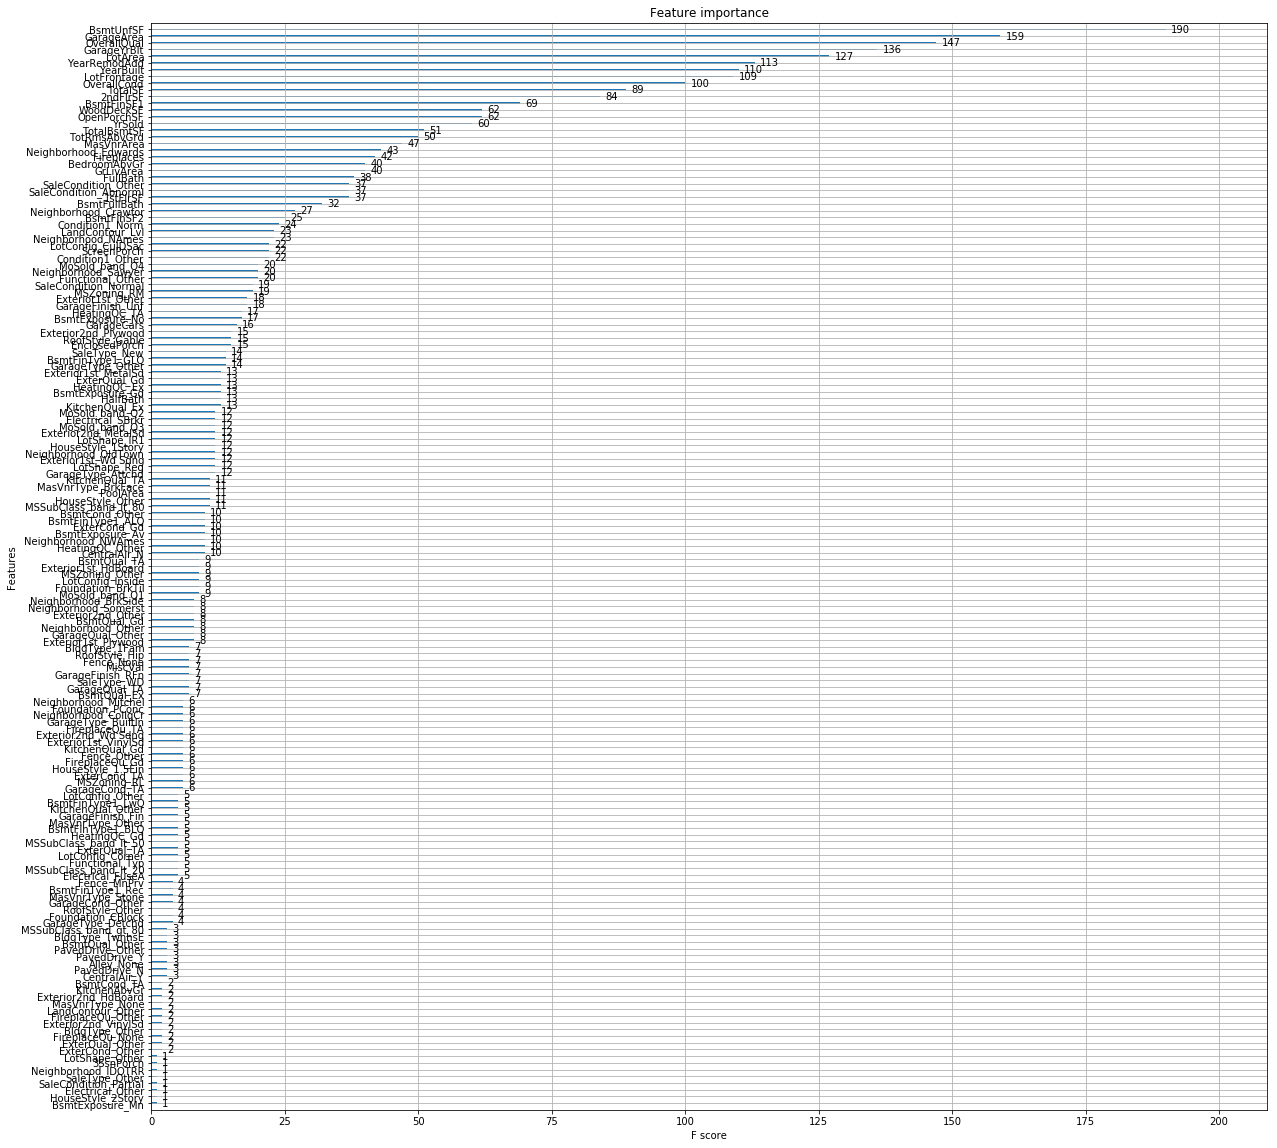

In [30]:
fig, ax = plt.subplots(1,1,figsize=(20,20))
xgb.plot_importance(model, ax=ax)

In [31]:
os.chdir(sys.path[0] + '\\Data')

best_model.save_model("Ames_XGB.model")

In [32]:
# Reload the Model

loaded_model = xgb.Booster()
loaded_model.load_model("Ames_XGB.model")

y = df_test['SalePrice'].values.astype(int)
X = df_test[ColumnList].values.astype(int)

dtest = xgb.DMatrix(X, label = y, feature_names = ColumnList, missing = -99)

# And use it for predictions.
y_test_pred = loaded_model.predict(dtest)

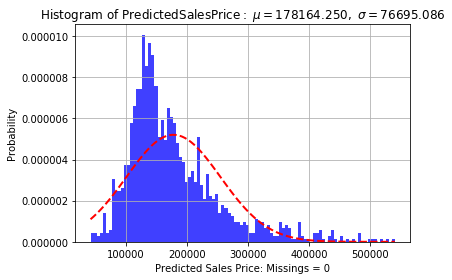

In [37]:
len(test_ID)
len(y_test_pred)

sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = y_test_pred
sub['SalePrice'] = np.exp(sub['SalePrice'] / 10000)

histogram(sub['SalePrice'], 'Predicted Sales Price', 'blue', 100)

In [35]:
sub.to_csv('submission.csv',index=False)

### The Submission Finished in the Top 26.25%.
* Not Bad considering the Data is Public and Likely Some Cheating Occurred Since One Person Got it 100% Right.
* For Improvement, Variables Should be Checked for MultiCollinearity and Alternative Transformation Should be Considered.

In [36]:
end_time = time.time()

diff = end_time - begin_time

print("run time ...", "\n")
print(diff, "seconds")
print(diff / 60, "minutes")
print(diff / 3600, "hours")

run time ... 

232.06059217453003 seconds
3.867676536242167 minutes
0.06446127560403613 hours
